In [32]:
!pip install xgboost
!pip install shap
!pip install tensorflow

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import shap
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import joblib
import seaborn as sns 

In [2]:
# Load dataset
df = pd.read_csv('F:/DS/project/ai4i2020.csv')

# Preview first few rows
print(df.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

In [3]:
# Check shape and info
print(df.shape)
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Basic statistics
print(df.describe())


(10000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(

In [4]:
print(df.columns)


Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')


In [5]:
print(df.dtypes[df.dtypes == "object"])


Product ID    object
Type          object
dtype: object


In [6]:
print(df['Machine failure'].value_counts())


Machine failure
0    9661
1     339
Name: count, dtype: int64


## SMOTE Oversampling

In [7]:
# 1. Drop non-predictive columns
df = df.drop(columns=['UDI', 'Product ID'], errors='ignore')

# 2. One-hot encode any categorical variables
df = pd.get_dummies(df, drop_first=True)

# 3. Separate features and target
X = df.drop('Machine failure', axis=1)
y = df['Machine failure']

# 4. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print(y_resampled.value_counts())


Machine failure
0    7246
1    7246
Name: count, dtype: int64


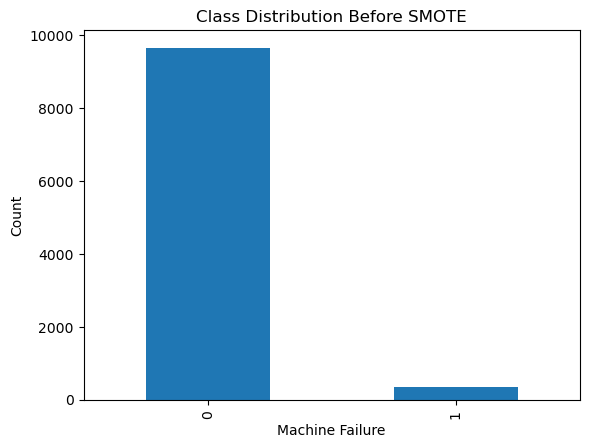

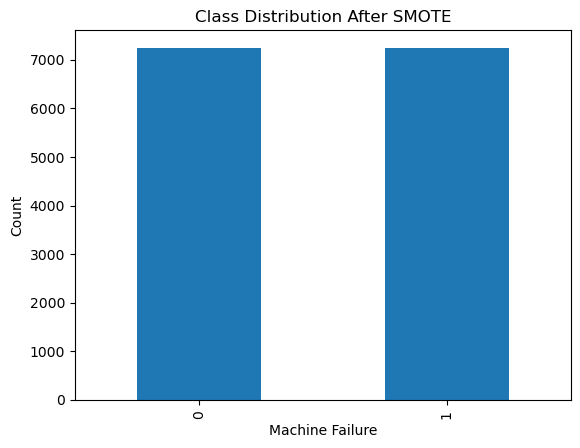

In [22]:
# Before SMOTE
y.value_counts().plot(kind='bar', title='Class Distribution Before SMOTE')
plt.xlabel('Machine Failure')
plt.ylabel('Count')
plt.savefig("class_distribution_before_smote.png", dpi=300, bbox_inches='tight')
plt.show()

# After SMOTE
y_resampled.value_counts().plot(kind='bar', title='Class Distribution After SMOTE')
plt.xlabel('Machine Failure')
plt.ylabel('Count')
plt.savefig("class_distribution_after_smote.png", dpi=300, bbox_inches='tight')
plt.show()


## Random forest

In [9]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)


RandomForestClassifier(random_state=42)

In [10]:
y_pred = rf_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]))


Confusion Matrix:
 [[2368   47]
 [   3   82]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      2415
           1       0.64      0.96      0.77        85

    accuracy                           0.98      2500
   macro avg       0.82      0.97      0.88      2500
weighted avg       0.99      0.98      0.98      2500


ROC-AUC Score: 0.9895603458774814


## XG Boost

In [11]:
from xgboost import XGBClassifier

# (Optional) Clean column names to avoid XGBoost issues
X_resampled.columns = X_resampled.columns.str.replace(r"[\[\]<>]", "", regex=True)
X_test.columns = X_test.columns.str.replace(r"[\[\]<>]", "", regex=True)

# Initialize model (without deprecated parameter)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Fit the model
xgb_model.fit(X_resampled, y_resampled)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)


In [12]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_xgb))

Confusion Matrix:
 [[2377   38]
 [   3   82]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      2415
           1       0.68      0.96      0.80        85

    accuracy                           0.98      2500
   macro avg       0.84      0.97      0.90      2500
weighted avg       0.99      0.98      0.98      2500


ROC-AUC Score: 0.974485446352454


## Support Vector Machine (SVM)

In [13]:
# Initialize SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Fit SVM
svm_model.fit(X_resampled, y_resampled)

# Predict
y_pred_svm = svm_model.predict(X_test)

# Results
print("Confusion Matrix (SVM):\n", confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report (SVM):\n", classification_report(y_test, y_pred_svm))
print("\nROC-AUC Score (SVM):", roc_auc_score(y_test, svm_model.predict_proba(X_test)[:,1]))

Confusion Matrix (SVM):
 [[1895  520]
 [  13   72]]

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.99      0.78      0.88      2415
           1       0.12      0.85      0.21        85

    accuracy                           0.79      2500
   macro avg       0.56      0.82      0.54      2500
weighted avg       0.96      0.79      0.85      2500


ROC-AUC Score (SVM): 0.8923785166240409


## LSTM (Long Short-Term Memory)

In [14]:
# Convert to float32
X_resampled = X_resampled.astype(np.float32)
X_test = X_test.astype(np.float32)

# Reshape for LSTM
X_train_lstm = np.expand_dims(X_resampled.values, axis=1)
X_test_lstm = np.expand_dims(X_test.values, axis=1)


# Reshape for LSTM: (samples, timesteps=1, features)
X_train_lstm = np.expand_dims(X_resampled.values, axis=1)
X_test_lstm = np.expand_dims(X_test.values, axis=1)

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_train_lstm.shape[2])))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
lstm_model.fit(X_train_lstm, y_resampled, epochs=10, batch_size=32, verbose=1)

# Predict
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print("Confusion Matrix (LSTM):\n", confusion_matrix(y_test, y_pred_lstm))
print("\nClassification Report (LSTM):\n", classification_report(y_test, y_pred_lstm))
print("\nROC-AUC Score (LSTM):", roc_auc_score(y_test, lstm_model.predict(X_test_lstm)))

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6744 - loss: 1.6387
Epoch 2/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8334 - loss: 0.3839
Epoch 3/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8503 - loss: 0.3600
Epoch 4/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8640 - loss: 0.3317
Epoch 5/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8739 - loss: 0.3093
Epoch 6/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8815 - loss: 0.2887
Epoch 7/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8968 - loss: 0.2582
Epoch 8/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9044 - loss: 0.2436
Epoch 9/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9053 - loss: 0.2350
Epoch 10/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9146 - loss: 0.2170
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix (LSTM):
 [[2346   69]
 [   3   82]]

Classification Report (LSTM):
               p

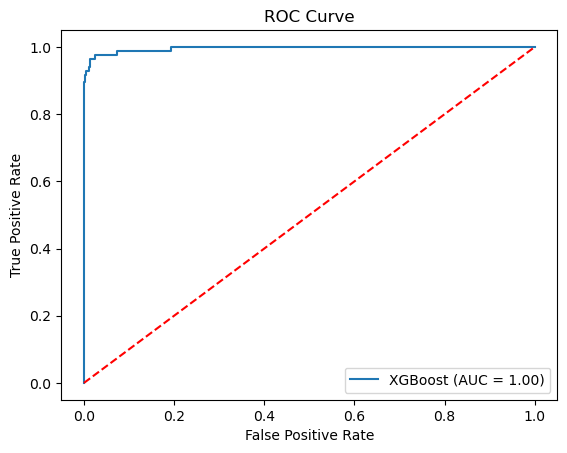

In [15]:

y_pred_proba = xgb_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'r--')  # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
Confusion matrixes 

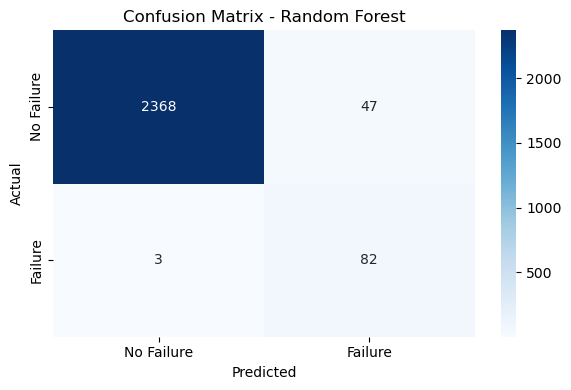

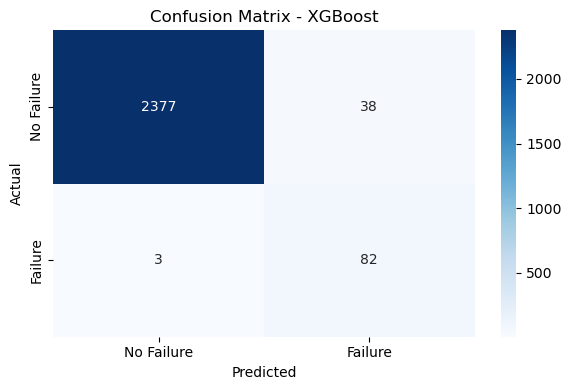

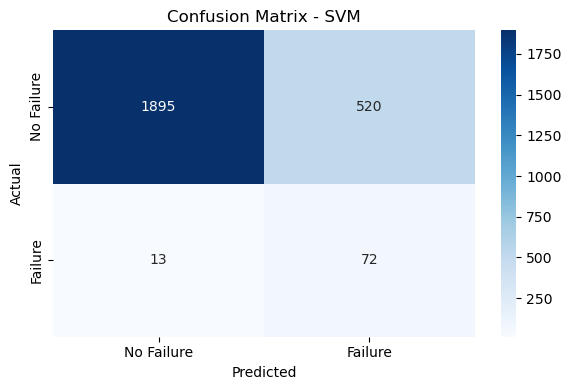

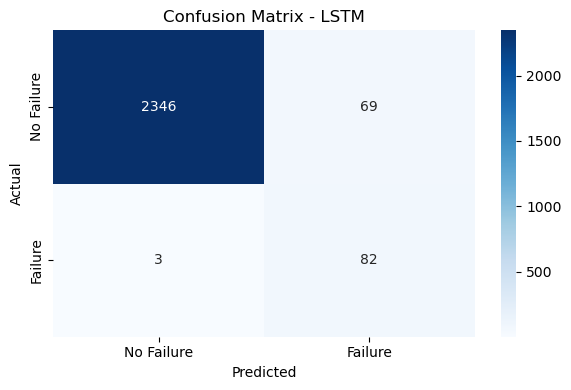

In [16]:
# Dictionary of models and their predictions
models_predictions = {
    "Random Forest": y_pred,       # RF predictions
    "XGBoost": y_pred_xgb,         # XGB predictions
    "SVM": y_pred_svm,             # SVM predictions
    "LSTM": y_pred_lstm            # LSTM predictions
}

# Loop through models and plot confusion matrices
for model_name, preds in models_predictions.items():
    cm = confusion_matrix(y_test, preds)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["No Failure", "Failure"], 
                yticklabels=["No Failure", "Failure"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_{model_name.replace(' ', '_')}.png")
    plt.show()

## Model performance comparison visual

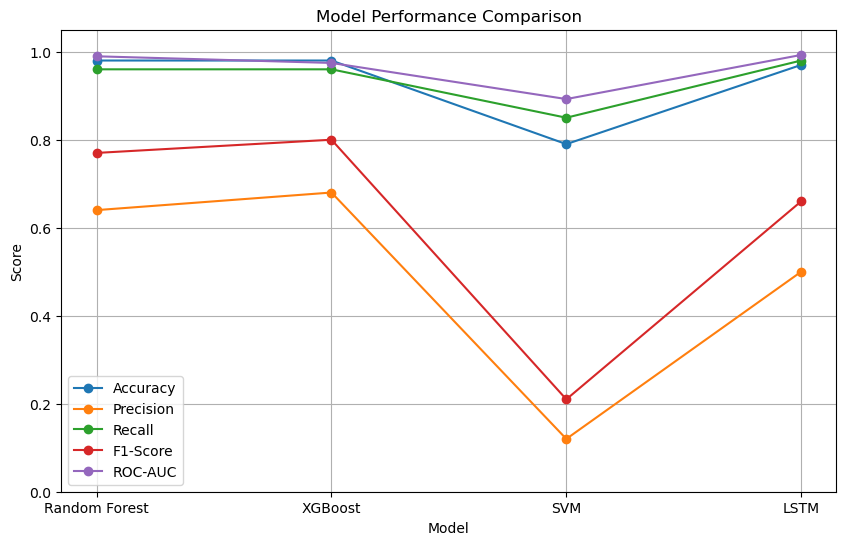

In [24]:
data = {
    "Model": ["Random Forest", "XGBoost", "SVM", "LSTM"],
    "Accuracy": [0.98, 0.98, 0.79, 0.97],
    "Precision": [0.64, 0.68, 0.12, 0.50],  # Precision for class 1
    "Recall": [0.96, 0.96, 0.85, 0.98],     # Recall for class 1
    "F1-Score": [0.77, 0.80, 0.21, 0.66],   # F1-score for class 1
    "ROC-AUC": [0.9896, 0.9745, 0.8924, 0.9927]
}

df = pd.DataFrame(data)

# Plot
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
plt.figure(figsize=(10, 6))

for metric in metrics:
    plt.plot(df["Model"], df[metric], marker='o', label=metric)

plt.ylim(0, 1.05)
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.savefig(f"comparision_{model_name.replace(' ', '_')}.png")
plt.show()

## SHAP Summary Plot

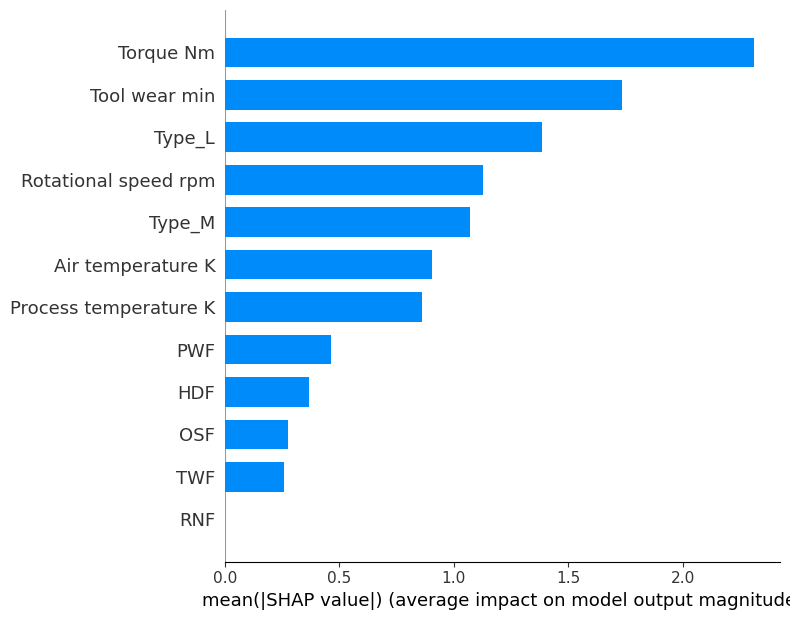

In [18]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


In [19]:
import joblib
joblib.dump(xgb_model, "xgboost_model.pkl")

['xgboost_model.pkl']

In [20]:
# Optional: Clean column names
X_resampled.columns = X_resampled.columns.str.replace(r"[\[\]<>]", "", regex=True)
X_test.columns = X_test.columns.str.replace(r"[\[\]<>]", "", regex=True)

# Scale features
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, "scaler.pkl")

# Save feature columns
joblib.dump(list(X_resampled.columns), "feature_columns.pkl")

# Initialize and fit model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_resampled_scaled, y_resampled)

# Save model
joblib.dump(xgb_model, "xgboost_model.pkl")

print("✅ Model, scaler, and feature list saved successfully!")


✅ Model, scaler, and feature list saved successfully!
